# Creating a ParticleGridCEM

In this tutorial we are going to create a Chemical Evolution Model from a set of individual simple stellar populations (referred to as particles). This is a common way of producing synthetic observations from particle-based hydrodynamical cosmological simulations, where each particle is represented by a single SSP.

For that purpose, PST provides the ``ParticleGridCEM`` class, that allows to build a chemical evolution model represented by a set of individual particles. The three input arguments required for creating the model are the following:

- time_form: formation time of the particles
- metallicities: metallicity of the particles
- masses: stellar mass of the particles


Import the required moduels for running this tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pst.SSP import PopStar
from pst import models
from astropy import units as u

## Initialising the CEM

Let's start by creating some mock particle data

In [2]:
np.random.seed(50)

# Number of particles
n_particles = 10000

# Randmonly sample the properties of each particle
particles_z = 0.02 * 10**(np.random.uniform(-3, 0.3, n_particles))  # log-spaced sampling in the range Z=(0.0001, 0.04)
particles_t_form= np.random.uniform(0, 13.7, n_particles) * u.Gyr
particles_mass = 10**(np.random.uniform(5, 6, n_particles)) * u.Msun

Text(0, 0.5, '$\\log_{10}(Z/Z_\\odot)$')

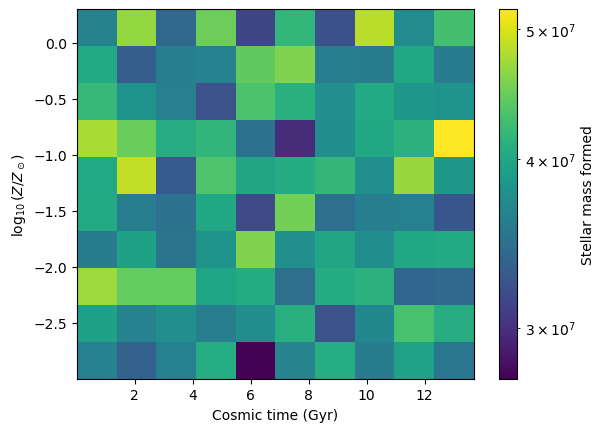

In [3]:
fig, ax = plt.subplots()

_, _, _, mappable = ax.hist2d(particles_t_form.value, np.log10(particles_z / 0.02),
                              weights=particles_mass.value, norm=LogNorm())
plt.colorbar(mappable, ax=ax, label="Stellar mass formed")
ax.set_xlabel("Cosmic time (Gyr)")
ax.set_ylabel(r"$\log_{10}(Z/Z_\odot)$")


Now we can construct the CEM

In [4]:
sfh_model = models.ParticleGridCEM(time_form=particles_t_form, metallicities=particles_z, masses=particles_mass)


To evaluate our model, let's define an array of times

In [5]:
cosmic_time = np.geomspace(1e-3, 13.7, 300) * u.Gyr

Text(0, 0.5, 'Stellar mass (Msun)')

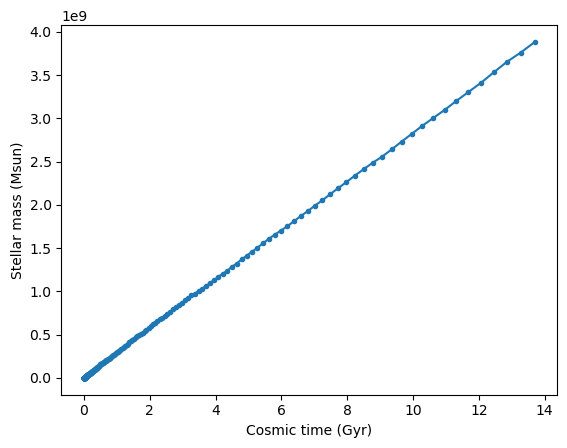

In [6]:
mass_history = sfh_model.stellar_mass_formed(cosmic_time)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cosmic_time, mass_history, '.-')
ax.set_xlabel("Cosmic time (Gyr)")
ax.set_ylabel("Stellar mass (Msun)")

In [7]:
ssp = PopStar(IMF='cha')
ssp.cut_wavelength(3000, 9000)

> Initialising Popstar models (IMF='cha')
--> Only stellar continuum
[SSP] Models cut between 3000.0 Angstrom 9000.0 Angstrom


Interpolate the CEM to the SSP

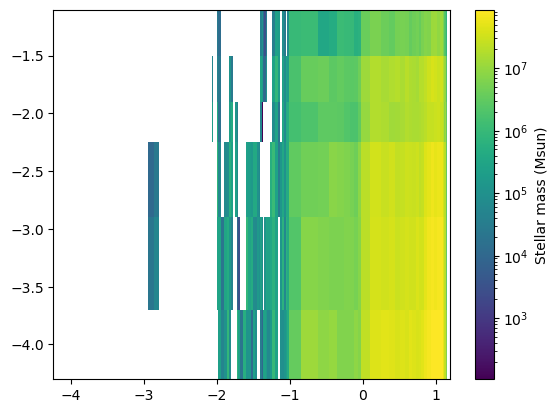

In [8]:
ssp_weights = sfh_model.interpolate_ssp_masses(ssp, t_obs=13.7 * u.Gyr)

fig = plt.figure()
ax = fig.add_subplot(111)
mappable = ax.pcolormesh(np.log10(ssp.ages.to_value("Gyr")), np.log10(ssp.metallicities), ssp_weights,
                         norm=LogNorm())
plt.colorbar(mappable, ax=ax, label="Stellar mass (Msun)")

Finally, generate the associated spectra to the CEM

Text(0, 0.5, '$L_\\lambda$(solLum / Angstrom)')

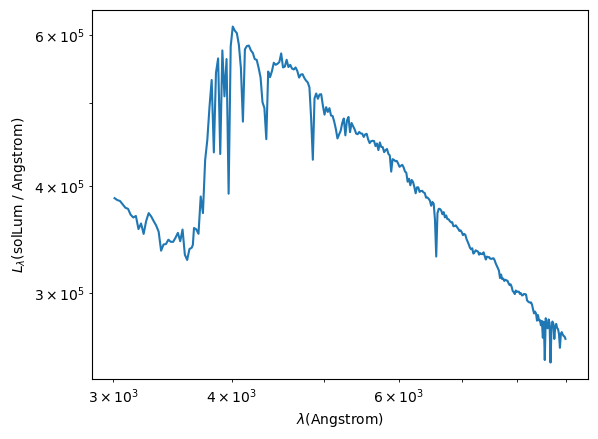

In [10]:
sed = sfh_model.compute_SED(ssp, t_obs=13.7 * u.Gyr)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(ssp.wavelength, sed)
ax.set_xlabel(r"$\lambda$ " + f"({ssp.wavelength.unit})")
ax.set_ylabel(r"$L_\lambda$ " + f"({sed.unit})")